In [92]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from keras.models import Sequential, Model,load_model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sn

In [80]:
#Process each image and put images and their label into df
data_dir = Path("flowers/")
train_data = []
train_label = []
df = pd.DataFrame(columns = ['Image', 'Label'])

i = 0

flower_type = {"daisy": 0, "dandelion": 1, "rose": 2, "sunflower": 3, "tulip": 4}
for x in os.walk(data_dir):
    if x[0] == "flowers":
        continue
    flower_label_name = x[0].split('\\')[-1]
    for flowers in x[1:]:
        for flower in flowers:
            imagePath = os.getcwd()+f"\\{data_dir}"+f"\\{flower_label_name}"+f"\\{flower}"
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (256,256))
            if image.shape[2] == 1:
                img = np.dstack([image,image,image])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = image.astype(np.float32)/255
            train_data.append(image)
            
            flower_label = flower_type[flower_label_name]
            train_label.append(flower_label)
            df = df.append({"Image": flower, "Label": flower_label_name}, ignore_index=True)
            


    print(f"{flower_label_name} Processed")

df=df.sample(frac=1).reset_index(drop=True)

daisy Processed
dandelion Processed
rose Processed
sunflower Processed
tulip Processed


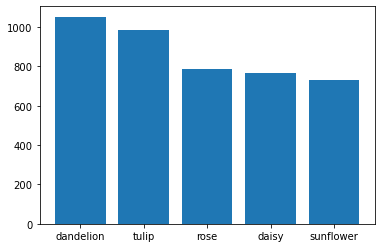

In [81]:
#Show number of images per label
plt.bar(df['Label'].value_counts().index, df['Label'].value_counts().values)
plt.show()

In [82]:
#Split data into training set, test set,
(x_train, x_test, y_train, y_test) = train_test_split(train_data, train_label, test_size=0.25, stratify=train_label)
# (x_train, x_val, y_train, y_val) = train_test_split(x_train, y_train, test_size=0.1, stratify=y_train)

In [83]:
#Creation of Model with 5 output layer for each Flower Type
model = Sequential()
model.add(Conv2D(32,(3,3), input_shape=(256,256,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(5))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])

In [84]:
#Changing labels to categorical and the input into numpy.array
Y_train = to_categorical(y_train, num_classes=5)
X_train = np.array(x_train)
X_test = np.array(x_test)
Y_test = to_categorical(y_test, num_classes=5)
print(Y_train.shape)
print(X_train.shape)

(3237, 5)
(3237, 256, 256, 3)


In [85]:
history = model.fit(x=X_train,y=Y_train, epochs=10, batch_size=256,
                   validation_data = (X_test, Y_test))

Epoch 1/10
13/13 [==============================] - 65s 4s/step - loss: 1.0702 - accuracy: 0.2524 - val_loss: 0.4962 - val_accuracy: 0.2981
Epoch 2/10
13/13 [==============================] - 46s 4s/step - loss: 0.5020 - accuracy: 0.3163 - val_loss: 0.4883 - val_accuracy: 0.4111
Epoch 3/10
13/13 [==============================] - 46s 4s/step - loss: 0.4574 - accuracy: 0.4285 - val_loss: 0.4316 - val_accuracy: 0.4981
Epoch 4/10
13/13 [==============================] - 45s 3s/step - loss: 0.4190 - accuracy: 0.4897 - val_loss: 0.3825 - val_accuracy: 0.5815
Epoch 5/10
13/13 [==============================] - 45s 3s/step - loss: 0.3962 - accuracy: 0.5252 - val_loss: 0.3925 - val_accuracy: 0.4759
Epoch 6/10
13/13 [==============================] - 45s 3s/step - loss: 0.3840 - accuracy: 0.5477 - val_loss: 0.4016 - val_accuracy: 0.5333
Epoch 7/10
13/13 [==============================] - 45s 3s/step - loss: 0.3569 - accuracy: 0.5953 - val_loss: 0.3854 - val_accuracy: 0.5444
Epoch 8/10
13/13 [==

34/34 [==============================] - 3s 81ms/step
              precision    recall  f1-score   support

       daisy       0.55      0.61      0.58       191
   dandelion       0.59      0.79      0.68       263
        rose       0.66      0.37      0.48       196
   sunflower       0.64      0.80      0.71       184
       tulip       0.69      0.50      0.58       246

    accuracy                           0.62      1080
   macro avg       0.63      0.62      0.61      1080
weighted avg       0.63      0.62      0.61      1080



<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

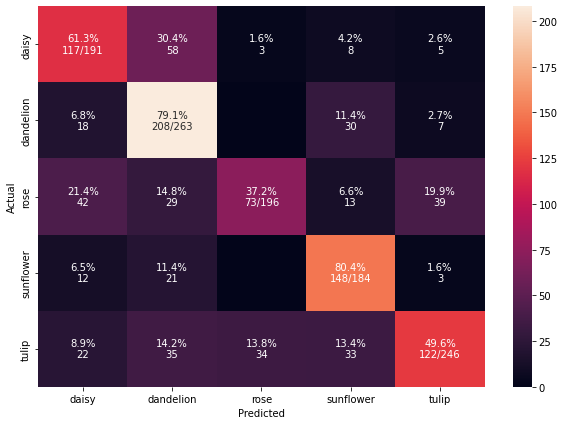

In [93]:
matrix_index = ["daisy", "dandelion", "rose","sunflower","tulip"]
preds = model.predict(X_test)
classpreds = np.argmax(preds, axis=1) # Predicted Classes
y_testclass = np.argmax(Y_test, axis =1) # True classes

cm = confusion_matrix(y_testclass, classpreds)

print(classification_report(y_testclass, classpreds, target_names = matrix_index))\

# Get percentage value for each element of the matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)


# Display confusion matrix 
df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,7))
sn.heatmap(df_cm, annot=annot, fmt='')